In [247]:
%matplotlib inline

In [248]:
import numpy as np
import pandas as pd
import os
import sys
import math
from sklearn.svm import SVR
from sklearn import preprocessing as pp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [249]:
# Importing Data
os.chdir('E:\Academics\Research\Data\Experimental data\Compression_test\Analysis\Input')
Raw_Data = pd.read_csv('Trial1.csv')


In [250]:
#Properties
Properties = ['Youngs_Modulus', 'Yield_Strength','Ultimate_Strength','Ductility']
Property = Properties[1]

In [251]:
#Converting pandas to numpy array
Data = Raw_Data[Raw_Data[Property].notnull()]
Data = Data.values

In [252]:
#Calculate mean
X = Data[:,0:-1]
Y = Data[:,-1]
X_mean = X.mean(axis = 0)
X_std = X.std(axis = 0)
Y_mean = Y.mean()
Y_std = Y.std(axis = 0)

In [253]:
#Scale Data
X = pp.scale(X)
Y = pp.scale(Y)

In [254]:
b = np.arange(len(Data))
print "Original:", b

Original: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [255]:
#Generate divisors of a number
def divisorGenerator(n):
    large_divisors = []
    for i in xrange(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor

In [256]:
#List all possible values of N
L = len(Data)
N = list(divisorGenerator(L))
N = N[1:-1]
N

[2, 4, 5, 8, 10, 20]

In [257]:
class Iteration(object):
    pass

In [258]:
poly_train_error = []
poly_test_error = []
rbf_train_error = []
rbf_test_error = []

Train_R2 = []
Test_R2 = []
Score = []
Score1 = []

In [259]:
np.random.shuffle(b)
for n in N:
    print n
    subs = np.array(np.split(b[:L], n))
    iterations = []
    for i in range(n):
        iteration = Iteration()
        # which step in the N-fold cross validation (which is test, which is train)
        j = range(n)
        del j[i]
        training_indices = np.concatenate(subs[j])
        testing_indices = subs[i]

        # create data subsets
        iteration.X_train = X[training_indices]
        iteration.X_test = X[testing_indices]
        iteration.Y_train = Y[training_indices]
        iteration.Y_actual = Y[testing_indices]
        
        X_train = X[training_indices]
        X_test = X[testing_indices]
        Y_train = Y[training_indices]
        Y_actual = Y[testing_indices]
        

        # Fit regression model
        svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
        svr_poly = SVR(kernel='poly', C=1e3, degree=3)
        
        #Predict output for testing and training data
        
        y_rbf_train = svr_rbf.fit(X_train, Y_train).predict(X_train)
        y_poly_train = svr_poly.fit(X_train, Y_train).predict(X_train)
        
        y_rbf_test = svr_rbf.fit(X_train, Y_train).predict(X_test)
        y_poly_test = svr_poly.fit(X_train, Y_train).predict(X_test)

        # Decentering the Data
        y_rbf_train_predict = y_rbf_train*Y_std + Y_mean
        y_poly_train_predict = y_poly_train*Y_std +Y_mean
        
        y_rbf_test_predict = y_rbf_test*Y_std + Y_mean
        y_poly_test_predict = y_poly_test*Y_std +Y_mean
        
        Y_train = Y_train*Y_std +Y_mean
        Y_actual = Y_actual*Y_std+Y_mean

        # test your model
        
        accuracies = cross_val_score(estimator = svr_rbf, X= X_train, y = Y_train, cv = 10 )
        accuracies1 = cross_val_score(estimator = svr_rbf, X= X_train, y = Y_train, cv = 10)
        score = accuracies.mean()
        score1 = accuracies1.mean()
        
        iteration.predict_train_rbf = y_rbf_train_predict
        iteration.predict_train_poly = y_poly_train_predict
        
        iteration.predict_test_rbf = y_rbf_test_predict
        iteration.predict_test_poly = y_poly_test_predict
        
        iteration.actual = Y_actual
        iteration.train = Y_train
        
        iteration.er_rbf_test = np.sqrt(mean_squared_error(Y_actual,y_rbf_test_predict,multioutput = 'uniform_average'))
        iteration.er_poly_test = np.sqrt(mean_squared_error(Y_actual,y_poly_test_predict,multioutput = 'uniform_average'))
        iteration.er_rbf_train = np.sqrt(mean_squared_error(Y_train,y_rbf_train_predict,multioutput = 'uniform_average'))
        iteration.er_poly_train = np.sqrt(mean_squared_error(Y_train,y_poly_train_predict,multioutput = 'uniform_average'))
        
        iteration.er_r2_train = r2_score(Y_train, y_rbf_train_predict,multioutput = 'uniform_average')
        iteration.er_r2_test = r2_score(Y_actual, y_rbf_test_predict,multioutput = 'uniform_average')

        # save the results (error in the testing data, error in the training data, etc.)
        iterations.append(iteration)
     
    error_rbf_train = np.array([it.er_rbf_train for it in iterations])
    error_rbf_test = np.array([it.er_rbf_test for it in iterations])
    
    error_poly_train = np.array([it.er_poly_train for it in iterations])
    error_poly_test = np.array([it.er_poly_test for it in iterations])
    
    er_r2_train = np.array([it.er_r2_train for it in iterations])
    er_r2_test = np.array([it.er_r2_test for it in iterations])
    
    error_rbf_train_avg = error_rbf_train.mean()
    error_rbf_test_avg = error_rbf_test.mean()
    
    error_poly_train_avg = error_poly_train.mean()
    error_poly_test_avg = error_poly_test.mean()
    
    poly_train_error.append(error_poly_train_avg)
    poly_test_error.append(error_poly_test_avg )
    
    rbf_train_error.append(error_rbf_train_avg)
    rbf_test_error.append(error_rbf_test_avg)
    
    Train_R2.append(er_r2_train.mean())
    Test_R2.append(er_r2_test.mean())
    Score.append(score)
    Score1.append(score1)
    
    

    

2
4
5
8
10
20


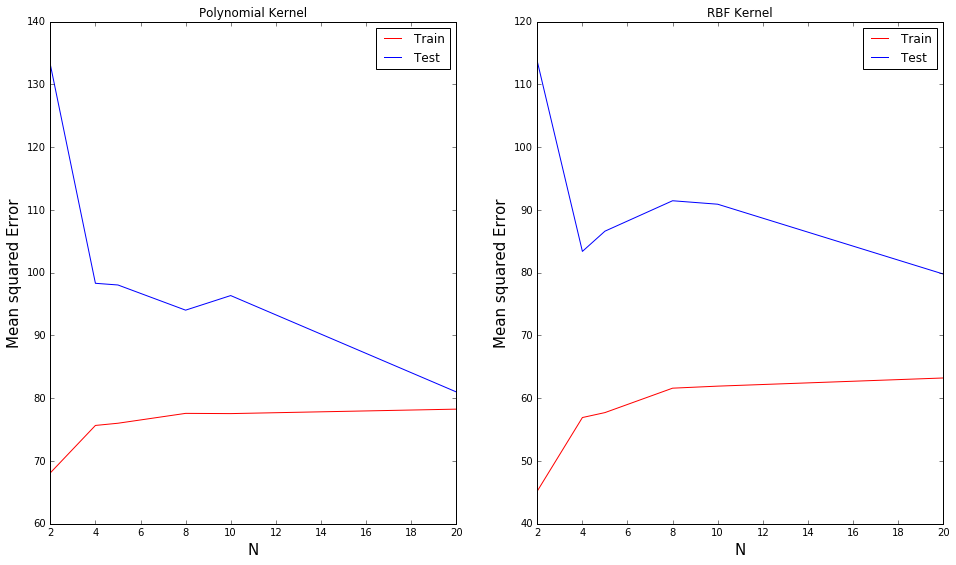

In [260]:
# plot your results
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x = N
y = poly_train_error
z = poly_test_error

y1 = rbf_train_error
z1 = rbf_test_error

ax1.plot(x, y,'r-',label = 'Train')
ax1.plot(x,z,'b-',label = 'Test')
ax1.set_xlabel('N',size = 15)
ax1.set_ylabel('Mean squared Error', size = 15)
ax1.set_title('Polynomial Kernel')
ax1.legend(loc = 'upper right')

ax2.plot(x, y1,'r-', label = 'Train')
ax2.plot(x,z1,'b-', label = 'Test')
ax2.set_xlabel('N', size = 15)
ax2.set_title('RBF Kernel')
ax2.set_ylabel('Mean squared Error', size = 15)
ax2.legend(loc = 'upper right')

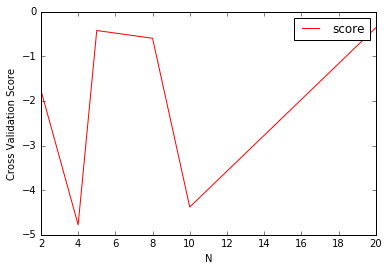

In [261]:
s = Score
plt.plot(x,s,'r-',label = 'score')
plt.xlabel('N')
plt.ylabel('Cross Validation Score')
plt.legend()


In [262]:
s

[-1.7633541055188622,
 -4.7756628281802307,
 -0.42336329107529169,
 -0.59684914900525921,
 -4.3779190930992211,
 -0.36260095627878597]